# Autoencoder for uninfected malaria cell images

## Imports

In [1]:
import os
import datetime

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.data import Dataset
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, SpatialDropout2D, LeakyReLU

In [2]:
tf.__version__

'2.3.0'

### Set logging to Error only

In [3]:
tf.get_logger().setLevel('ERROR')

### Check for GPU

In [4]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Constants

### Data Preparation

In [5]:
RANDOM_STATE = 7
BASE_PATH = r"..\..\Datasets\Malaria Cell Images\Uninfected"
IMAGE_SIZE = (128, 128)
VAL_SIZE = 0.05
BATCH_SIZE = 64
SHUFFLE_BUFFER_SIZE = 1_000

### Training

In [6]:
EPOCHS = 100
LEARNING_RATE = 0.004

### Callbacks

In [7]:
EARLY_STOP_PATIENCE = 10
REDUCE_LR_FACTOR = 0.2
REDUCE_LR_PATIENCE = 4
REDUCE_LR_COOLDOWN = 3
REDUCE_LR_MIN = 1e-5

### Saving

In [8]:
PLOTS_DPI = 200
MODEL_NAME = 'Autoencoder_Reconstruction'
PLOTS_DIR = os.path.join('plots', MODEL_NAME)
TB_LOGS = "tensorboard_logs/Autoencoder_Reconstruction/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

## Data Loading

In [9]:
image_names = Dataset.list_files(os.path.join(BASE_PATH, '*.png'), seed = RANDOM_STATE)
image_count = image_names.cardinality().numpy()
print(f"\nTotal number of image files: {image_count}")


Total number of image files: 13779


### Image data loading with augmentations

In [10]:
def load_augmented_images(file_path):
    img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, IMAGE_SIZE)

    img_rotneg90 = tf.image.rot90(img, k = -1)
    img_rotpos90 = tf.image.rot90(img, k = 1)

    return img_rotneg90/255.0, img/255.0, img_rotpos90/255.0

image_data = image_names.map(load_augmented_images, num_parallel_calls = AUTOTUNE)
image_data = image_data.flat_map(lambda rotneg90, original, rotpos90: Dataset.from_tensor_slices([rotneg90, original, rotpos90]))


### Augmented data visualization

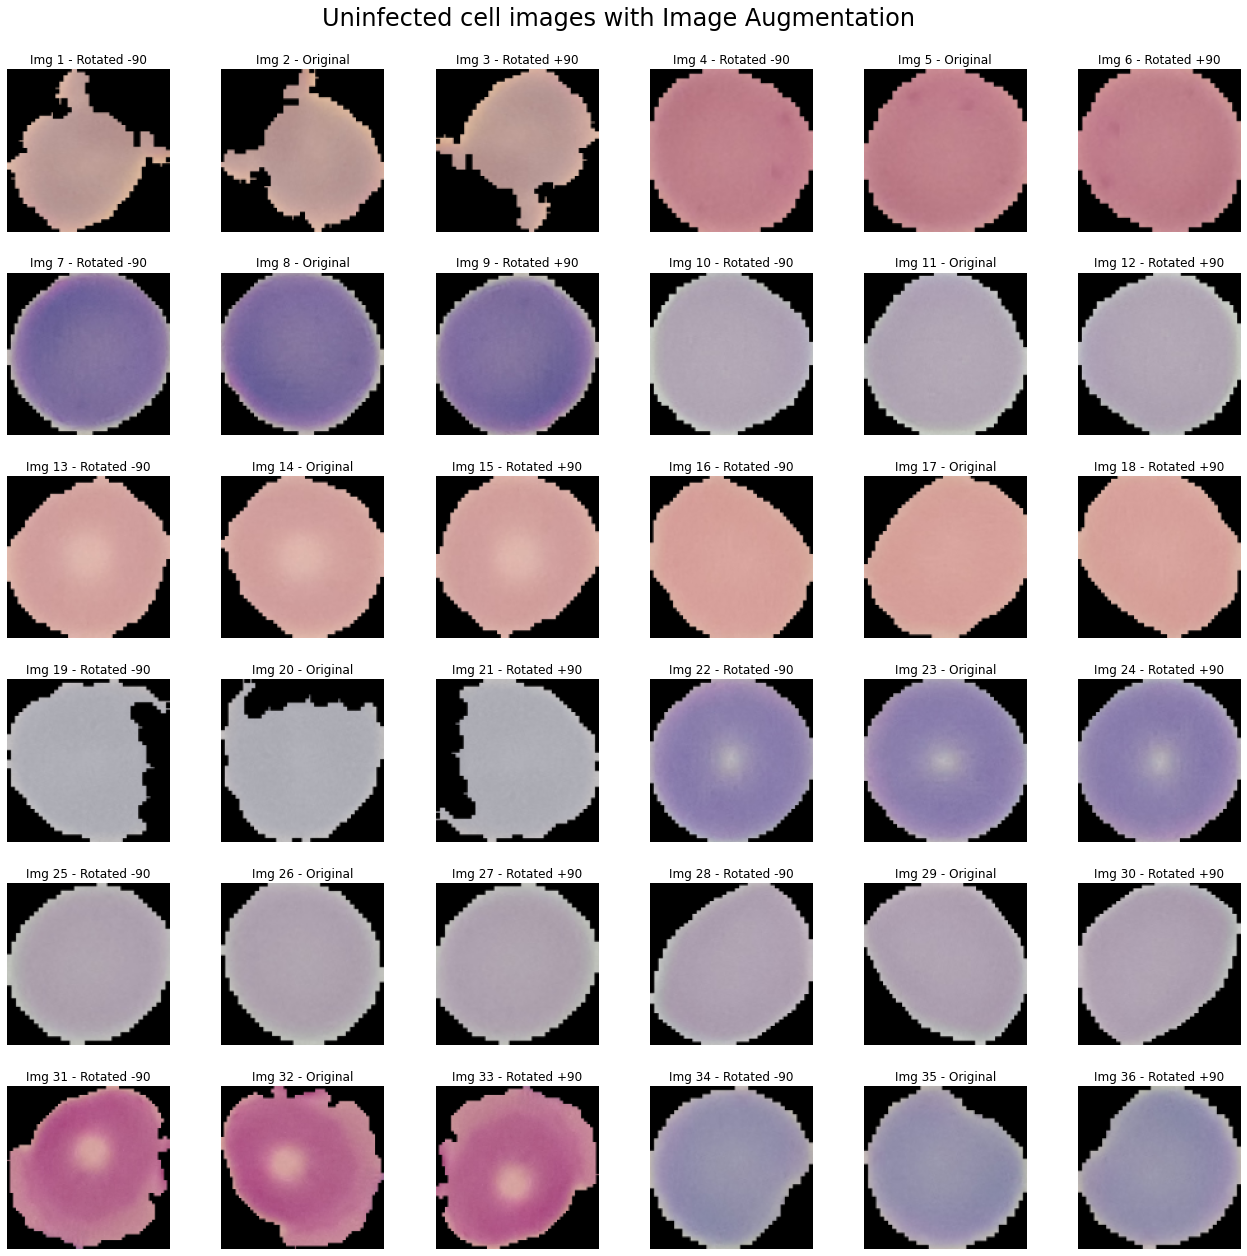

In [11]:
title_suffixes = ['Rotated -90', 'Original', 'Rotated +90']

plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))
plt.suptitle('Uninfected cell images with Image Augmentation', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

for i, img in enumerate(image_data.take(36)):
    plt.subplot(6, 6, i + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Img {i + 1} - {title_suffixes[i % 3]}")
    plt.imshow(img.numpy())

### Data splitting

In [12]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size = SHUFFLE_BUFFER_SIZE)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size = AUTOTUNE)
  return ds

def create_autoencoder_dataset(img):
    return img, img

In [13]:
val_image_count = int(image_count * VAL_SIZE * 3)

train_images = image_data.skip(val_image_count)
val_images = image_data.take(val_image_count)

train_ds = configure_for_performance(train_images.map(create_autoencoder_dataset))
val_ds = configure_for_performance(val_images.map(create_autoencoder_dataset))

## Model Creation

### Input Layer

In [14]:
inputLayer = Input(shape = (*IMAGE_SIZE, 3), name = 'Input')

### Encoder

In [15]:
depth_conv = SeparableConv2D(16, (4, 4), activation = LeakyReLU(), padding = 'same', name = "Depth_Conv")(inputLayer)
depth_conv.shape

TensorShape([None, 128, 128, 16])

In [16]:
conv_1 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_1")(depth_conv)
pool_1 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_1")(conv_1)
pool_1.shape

TensorShape([None, 32, 32, 32])

In [17]:
conv_2 = Conv2D(64, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_2")(pool_1)
pool_2 = MaxPooling2D((4, 4), padding = 'same', name = "Enc_MaxPool_2")(conv_2)
pool_2.shape

TensorShape([None, 8, 8, 64])

In [18]:
conv_3 = Conv2D(128, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_3")(pool_2)
pool_3 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_3")(conv_3)
pool_3.shape

TensorShape([None, 4, 4, 128])

In [19]:
conv_4 = Conv2D(256, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Enc_Conv_4")(pool_3)
pool_4 = MaxPooling2D((2, 2), padding = 'same', name = "Enc_MaxPool_4")(conv_4)
pool_4.shape

TensorShape([None, 2, 2, 256])

### Dropout

In [20]:
dropout_1 = SpatialDropout2D(0.1, name = "Dropout_1")(pool_4)
dropout_1.shape

TensorShape([None, 2, 2, 256])

### Decoder

In [21]:
conv_5 = Conv2D(128, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_1")(dropout_1)
up_1 = UpSampling2D((2, 2), name = "Dec_Upsampling_1")(conv_5)
up_1.shape

TensorShape([None, 4, 4, 128])

In [22]:
conv_6 = Conv2D(64, (2, 2), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_2")(up_1)
up_2 = UpSampling2D((2, 2), name = "Dec_Upsampling_2")(conv_6)
up_2.shape

TensorShape([None, 8, 8, 64])

In [23]:
conv_7 = Conv2D(32, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_3")(up_2)
up_3 = UpSampling2D((4, 4), name = "Dec_Upsampling_3")(conv_7)
up_3.shape

TensorShape([None, 32, 32, 32])

In [24]:
conv_8 = Conv2D(16, (3, 3), activation = LeakyReLU(), padding = 'same', name = "Dec_Conv_4")(up_3)
up_4 = UpSampling2D((4, 4), name = "Dec_Upsampling_4")(conv_8)
up_4.shape

TensorShape([None, 128, 128, 16])

### Dropout

In [25]:
dropout_2 = SpatialDropout2D(0.1, name = "Dropout_2")(up_4)
dropout_2.shape

TensorShape([None, 128, 128, 16])

### Output

In [26]:
outputLayer = SeparableConv2D(3, (4, 4), activation = 'sigmoid', padding = 'same', name = 'Reconstruction_Output')(dropout_2)
outputLayer.shape

TensorShape([None, 128, 128, 3])

### Model compilation

In [27]:
autoencoder = Model(inputs = inputLayer, outputs = outputLayer, name = MODEL_NAME)
autoencoder.compile(optimizer = Adam(LEARNING_RATE), loss = 'binary_crossentropy', metrics = ['mse'])

### Model Summary

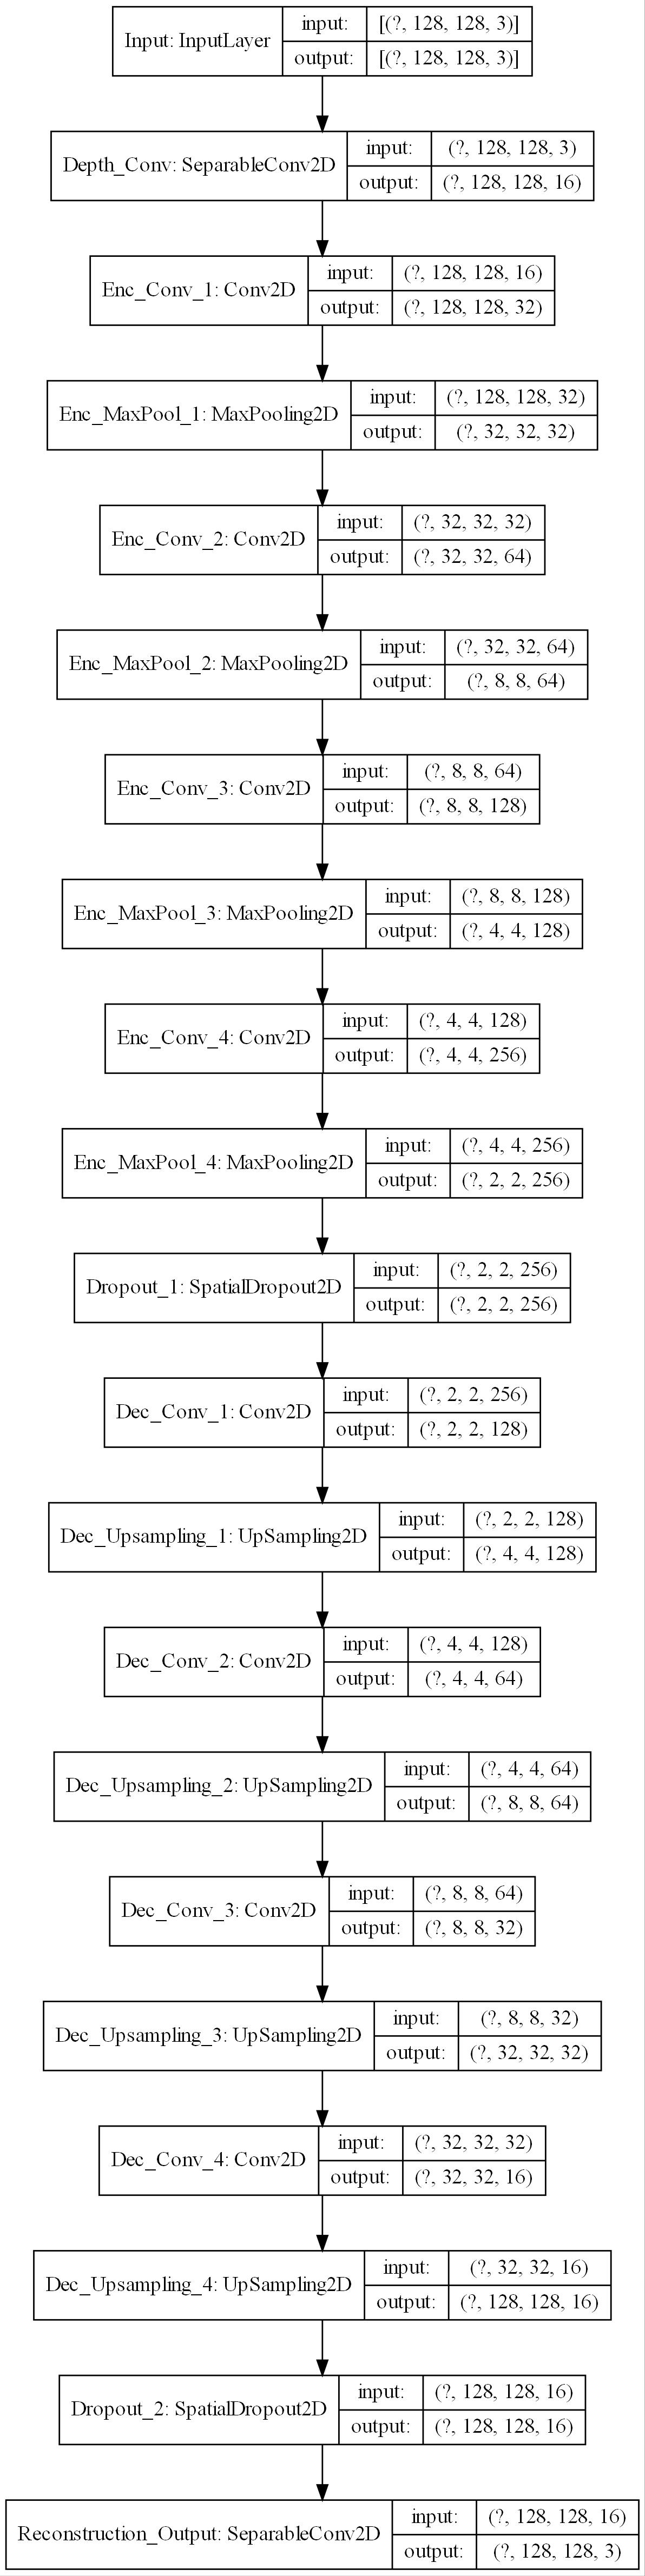

In [28]:
tf.keras.utils.plot_model(autoencoder, to_file = os.path.join(PLOTS_DIR, 'model.jpg'), show_shapes = True, dpi = PLOTS_DPI)

In [29]:
autoencoder.summary()

Model: "Autoencoder_Reconstruction"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 128, 128, 3)]     0         
_________________________________________________________________
Depth_Conv (SeparableConv2D) (None, 128, 128, 16)      112       
_________________________________________________________________
Enc_Conv_1 (Conv2D)          (None, 128, 128, 32)      4640      
_________________________________________________________________
Enc_MaxPool_1 (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
Enc_Conv_2 (Conv2D)          (None, 32, 32, 64)        18496     
_________________________________________________________________
Enc_MaxPool_2 (MaxPooling2D) (None, 8, 8, 64)          0         
_________________________________________________________________
Enc_Conv_3 (Conv2D)          (None, 8, 8

## Model Training

### Callbacks

In [30]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = EARLY_STOP_PATIENCE, restore_best_weights = True)

tensorboard = TensorBoard(log_dir = TB_LOGS)

reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss', 
    factor = REDUCE_LR_FACTOR, 
    patience = REDUCE_LR_PATIENCE, 
    verbose = 1, cooldown = 
    REDUCE_LR_COOLDOWN, 
    min_lr = REDUCE_LR_MIN
)

### Training history

In [31]:
%%time

history = autoencoder.fit(
    train_ds, 
    epochs = EPOCHS, 
    verbose = 1, 
    validation_data = val_ds,
    callbacks = [early_stop, tensorboard, reduce_lr]
    )

Epoch 1/100
614/614 [==============================] - 182s 296ms/step - loss: 0.5108 - mse: 0.0194 - val_loss: 0.4903 - val_mse: 0.0118
Epoch 2/100
614/614 [==============================] - 174s 284ms/step - loss: 0.4872 - mse: 0.0110 - val_loss: 0.4844 - val_mse: 0.0095
Epoch 3/100
614/614 [==============================] - 173s 281ms/step - loss: 0.4832 - mse: 0.0096 - val_loss: 0.4809 - val_mse: 0.0085
Epoch 4/100
614/614 [==============================] - 165s 269ms/step - loss: 0.4813 - mse: 0.0090 - val_loss: 0.4797 - val_mse: 0.0081
Epoch 5/100
614/614 [==============================] - 172s 280ms/step - loss: 0.4800 - mse: 0.0085 - val_loss: 0.4790 - val_mse: 0.0077
Epoch 6/100
614/614 [==============================] - 167s 272ms/step - loss: 0.4794 - mse: 0.0083 - val_loss: 0.4781 - val_mse: 0.0074
Epoch 7/100
614/614 [==============================] - 168s 273ms/step - loss: 0.4789 - mse: 0.0081 - val_loss: 0.4787 - val_mse: 0.0077
Epoch 8/100
614/614 [====================

## Model Evaluation

### Model Loss over Epochs

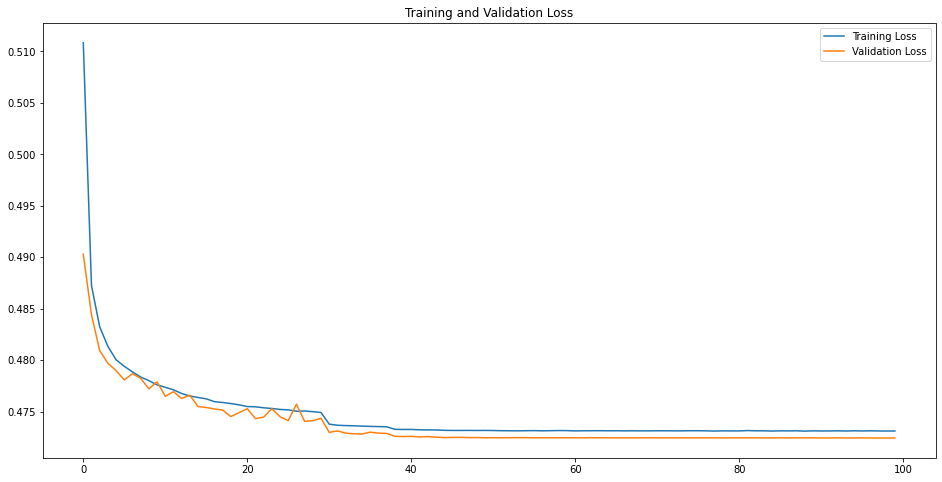

In [32]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = history.epoch

plt.figure(figsize = (16, 8))
plt.plot(epochs_range, loss, label = 'Training Loss')
plt.plot(epochs_range, val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')
plt.savefig(os.path.join(PLOTS_DIR, 'acc_and_loss.jpg'), dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

### Prediction Visualization

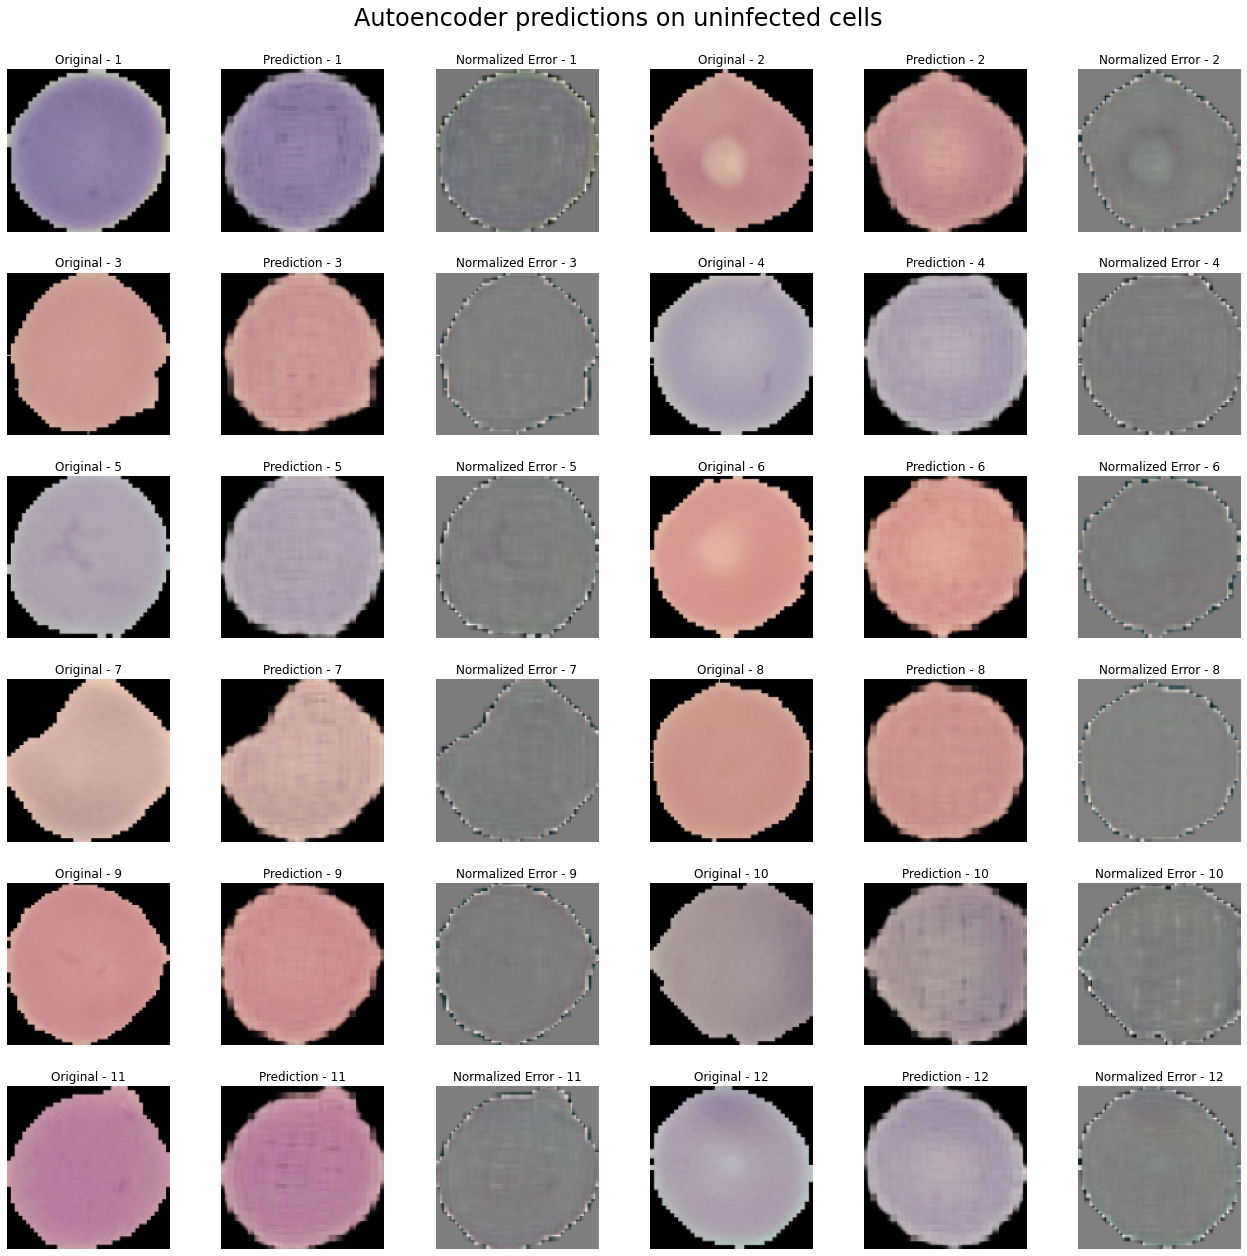

In [33]:
plt.subplots(nrows = 6, ncols = 6, figsize = (18, 18))

plt.suptitle('Autoencoder predictions on uninfected cells', fontsize = 24)
plt.tight_layout(rect = [0, 0, 1, 0.97], h_pad = 2)

for i in val_ds.take(1):
    val_data = i[0][:12].numpy()

val_data = np.array(val_data)
pred = autoencoder.predict(val_data)
pred_error = val_data - pred
pred_error_min = pred_error.min(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
pred_error_max = pred_error.max(axis = (1, 2, 3)).reshape(12, 1, 1, 1)
norm_error = (pred_error - pred_error_min)/(pred_error_max - pred_error_min)

for i in range(len(val_data)):
    plt.subplot(6, 6, (3 * i) + 1)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Original - {i + 1}")
    plt.imshow(val_data[i])

    plt.subplot(6, 6, (3 * i) + 2)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Prediction - {i + 1}")
    plt.imshow(pred[i])

    plt.subplot(6, 6, (3 * i) + 3)
    plt.axis(False)
    plt.grid(False)
    plt.title(f"Normalized Error - {i + 1}")
    plt.imshow(norm_error[i])

plt.savefig(os.path.join(PLOTS_DIR, 'predictions.jpg'), dpi = PLOTS_DPI, bbox_inches='tight')
plt.show()

## Model Saving

In [34]:
autoencoder.save(os.path.join('models', MODEL_NAME))